In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
import sys,os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
# df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
# df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
# df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50.json')
# with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
#     articles = pickle.load(fp)
# df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), df_hd_tp_dnf.keys()

In [5]:
dnf300 = pd.read_json('../evaluation_set/deepnofakes/dnf_300/combined_300.json').T
dnf_eval = pd.read_json('../evaluation_set/deepnofakes/Evaluation_Final_50_V2.json')
dnf_eval.columns = ['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('../evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('../evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('../evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf300.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type',
        'urls'],
       dtype='object'),
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'type', 'urls'], dtype='object'),
 300,
 300)

In [6]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [48]:
# id_word_mapping = {}

In [7]:

for idx in tqdm_notebook(dnf300.id.unique()):
    hd = dnf300[dnf300.id==idx]['headline'].values[0]
#     ar_id = dnf300[dnf300.id==idx]['id'].values[0]
#     cl = df_ar_cl[df_ar_cl.Article==title]['Claim'].values
#     if len(cl)<1:
#         continue
#     print('ar_id:',ar_id)
#     print('hd:',hd)
#     print('cl_1:',cl[0])
    
#     with open('evaluation_set/deepnofakes/cleaned/article_{0}.txt'.format(ar_id)) as f:
#         article = f.readlines()

#     article=''.join(article)
#     # print(article)
#     article = article.replace('[REF]','')
#     doc = sentencizer(article)
#     sentences = [sent.string.strip() for sent in doc.sents]

    sentences = articles[idx]
    tokens_hd = nlp(hd.lower())
    for token in tokens_hd:
        if id_word_mapping.get(token.rank) == None:
            id_word_mapping[token.rank] = []
            id_word_mapping[token.rank].append(token.text)
        else:
            id_word_mapping[token.rank].append(token.text)
            id_word_mapping[token.rank] = list(set(id_word_mapping[token.rank]))

    for i in range(len(sentences)):
        tokens_s = nlp(sentences[i].lower())
        for token in tokens_s:
            if id_word_mapping.get(token.rank) == None:
                id_word_mapping[token.rank] = []
                id_word_mapping[token.rank].append(token.text)
            else:
                id_word_mapping[token.rank].append(token.text)
                id_word_mapping[token.rank] = list(set(id_word_mapping[token.rank]))
                
#             if id_word_mapping[token.rank] != None:
#                 print('1')
#             break
#         break
#     break
# break
    
    




In [8]:
len(id_word_mapping.keys())

15274

In [10]:
id_word_mapping_file = '../evaluation_set/word_mapping/id_word_mapping.p'
outfile = open(id_word_mapping_file,'wb')
pickle.dump(id_word_mapping,outfile)
outfile.close()

In [82]:
tdg = datagen_cdc(batchsize,df_hd_tp_cdc,mode='train')
vdg = datagen_cdc(batchsize,df_hd_tp_cdc,mode='val')
test_dg = datagen_dnf(1,df_hd_tp_dnf)

In [83]:
x,y = next(test_dg)

In [84]:
x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

((1, 1300, 300), (1, 300), (1, 50, 20000))

In [11]:
# class Attention_Layer(Layer):
#     def __init__(self,ch,**kwargs):
#         self.channels=ch
# #         self.h_w=self.channels//8
#         super(Attention_Layer,self).__init__(**kwargs)

#     def build(self,input_shape):
# #         kernel_shape=(1, 3, 3) + (self.channels, self.h_w)
# #         print(input_shape)
#         self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
#         super(Attention_Layer, self).build(input_shape)

#     def call(self, x):
# #         print('input shape:',x.shape) # None, 16,12,512
#         s,h = 
#         exp_x = K.expand_dims(x,axis=-1)
# #         print('expanded input shape:',exp_x.shape) # N, 16, 12, 512, 1
# #         filters = Attention Heads
#         conv3d = kl.Conv3D(padding='same',filters=1, kernel_size=(3,3,512), strides=(1,1,512),kernel_initializer='he_normal',activation='relu')(exp_x)
# #         print('conv3d shape:', conv3d.shape)
#         conv3d = K.squeeze(K.squeeze(conv3d, axis=-1),axis=-1)
# #         print('conv3d shape:', conv3d.shape)
#         conv3d = K.expand_dims(conv3d,axis=1) # N, 1, 16, 12
# #         print('conv3d shape:', conv3d.shape)
#         softmax_alpha = K.softmax(conv3d, axis=1) # attention map # N, 16, 12
# #         print('softmax_alpha shape:', softmax_alpha.shape)
#         softmax_alpha = K.squeeze(softmax_alpha, axis=1) 
# #         print('softmax_alpha shape:', softmax_alpha.shape)
#         exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1) # for elementwise multiplication
# #         print('exp_softmax_alpha shape:', exp_softmax_alpha.shape)
        
#         u = kl.multiply([exp_softmax_alpha, x])
        
#         u = (self.gamma * u) + (self.gamma * u * x)
# #         print('u shape:', u.shape)
#         return u
# #         return [u, softmax_alpha, self.gamma]

#     def compute_output_shape(self, input_shape): 
#         return input_shape
# #         return [input_shape,(None,16,12),(None,1)]
    
#     def get_config(self):
#         return super(Attention_Layer,self).get_config()

In [12]:
def build_model():
    inp_sentence_vectors = Input(shape=(1300, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu')(conv1)
    conv2 = Dropout(0.5)(conv2)
    gap = GlobalAveragePooling1D()(conv2)
    repeat = RepeatVector(50)(gap)
    lstm = LSTM(256,return_sequences=True)(repeat)
    lstm = Dropout(0.5)(lstm)
    timeDist = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm)
    model = Model(inp_sentence_vectors,timeDist)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 1300, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1300, 16)          14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1300, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1298, 32)          1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1298, 32)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 50, 32)            0         
__________

In [13]:
hist = model.fit_generator(tdg
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,
                           ,epochs=epochs)

Epoch 1/500
16/16 [==============================] - 56s 4s/step - loss: 8.7505 - acc: 0.7900 - val_loss: 5.1442 - val_acc: 0.8446
Epoch 2/500
16/16 [==============================] - 48s 3s/step - loss: 2.2803 - acc: 0.8420 - val_loss: 1.3772 - val_acc: 0.8469
Epoch 3/500
16/16 [==============================] - 48s 3s/step - loss: 1.3226 - acc: 0.8417 - val_loss: 1.3046 - val_acc: 0.8440
Epoch 4/500
16/16 [==============================] - 48s 3s/step - loss: 1.2471 - acc: 0.8408 - val_loss: 1.2521 - val_acc: 0.8448
Epoch 5/500
16/16 [==============================] - 46s 3s/step - loss: 1.1825 - acc: 0.8463 - val_loss: 1.2558 - val_acc: 0.8437
Epoch 6/500
16/16 [==============================] - 48s 3s/step - loss: 1.1739 - acc: 0.8447 - val_loss: 1.2431 - val_acc: 0.8426
Epoch 7/500
16/16 [==============================] - 48s 3s/step - loss: 1.1600 - acc: 0.8439 - val_loss: 1.1696 - val_acc: 0.8469
Epoch 8/500
16/16 [==============================] - 46s 3s/step - loss: 1.1247 - a

Epoch 125/500
16/16 [==============================] - 48s 3s/step - loss: 0.5268 - acc: 0.8667 - val_loss: 0.6659 - val_acc: 0.8570
Epoch 126/500
16/16 [==============================] - 47s 3s/step - loss: 0.5162 - acc: 0.8686 - val_loss: 0.6456 - val_acc: 0.8619
Epoch 127/500
16/16 [==============================] - 47s 3s/step - loss: 0.5406 - acc: 0.8634 - val_loss: 0.6602 - val_acc: 0.8592
Epoch 128/500
16/16 [==============================] - 47s 3s/step - loss: 0.5082 - acc: 0.8710 - val_loss: 0.6460 - val_acc: 0.8613
Epoch 129/500
16/16 [==============================] - 47s 3s/step - loss: 0.5164 - acc: 0.8677 - val_loss: 0.6566 - val_acc: 0.8579
Epoch 130/500
16/16 [==============================] - 47s 3s/step - loss: 0.5098 - acc: 0.8689 - val_loss: 0.6539 - val_acc: 0.8619
Epoch 131/500
16/16 [==============================] - 46s 3s/step - loss: 0.5216 - acc: 0.8652 - val_loss: 0.6646 - val_acc: 0.8595
Epoch 132/500
16/16 [==============================] - 47s 3s/step - 

Epoch 248/500
16/16 [==============================] - 47s 3s/step - loss: 0.3520 - acc: 0.8994 - val_loss: 0.6339 - val_acc: 0.8749
Epoch 249/500
16/16 [==============================] - 48s 3s/step - loss: 0.3504 - acc: 0.8989 - val_loss: 0.6450 - val_acc: 0.8742
Epoch 250/500
16/16 [==============================] - 47s 3s/step - loss: 0.3760 - acc: 0.8927 - val_loss: 0.6264 - val_acc: 0.8763
Epoch 251/500
16/16 [==============================] - 47s 3s/step - loss: 0.3604 - acc: 0.8973 - val_loss: 0.6254 - val_acc: 0.8760
Epoch 252/500
16/16 [==============================] - 47s 3s/step - loss: 0.3416 - acc: 0.9004 - val_loss: 0.5988 - val_acc: 0.8796
Epoch 253/500
16/16 [==============================] - 48s 3s/step - loss: 0.3456 - acc: 0.9005 - val_loss: 0.6090 - val_acc: 0.8818
Epoch 254/500
16/16 [==============================] - 47s 3s/step - loss: 0.3384 - acc: 0.9011 - val_loss: 0.6584 - val_acc: 0.8738
Epoch 255/500
16/16 [==============================] - 47s 3s/step - 

Epoch 371/500
16/16 [==============================] - 47s 3s/step - loss: 0.2497 - acc: 0.9257 - val_loss: 0.6628 - val_acc: 0.8872
Epoch 372/500
16/16 [==============================] - 48s 3s/step - loss: 0.2493 - acc: 0.9253 - val_loss: 0.6628 - val_acc: 0.8889
Epoch 373/500
16/16 [==============================] - 47s 3s/step - loss: 0.2491 - acc: 0.9256 - val_loss: 0.6166 - val_acc: 0.8871
Epoch 374/500
16/16 [==============================] - 47s 3s/step - loss: 0.2446 - acc: 0.9264 - val_loss: 0.6195 - val_acc: 0.8899
Epoch 375/500
16/16 [==============================] - 48s 3s/step - loss: 0.2422 - acc: 0.9276 - val_loss: 0.6319 - val_acc: 0.8893
Epoch 376/500
16/16 [==============================] - 48s 3s/step - loss: 0.2443 - acc: 0.9266 - val_loss: 0.6333 - val_acc: 0.8861
Epoch 377/500
16/16 [==============================] - 47s 3s/step - loss: 0.2506 - acc: 0.9241 - val_loss: 0.6472 - val_acc: 0.8853
Epoch 378/500
16/16 [==============================] - 48s 3s/step - 

Epoch 494/500
16/16 [==============================] - 47s 3s/step - loss: 0.1810 - acc: 0.9451 - val_loss: 0.6846 - val_acc: 0.8870
Epoch 495/500
16/16 [==============================] - 47s 3s/step - loss: 0.1915 - acc: 0.9422 - val_loss: 0.7161 - val_acc: 0.8836
Epoch 496/500
16/16 [==============================] - 47s 3s/step - loss: 0.1950 - acc: 0.9419 - val_loss: 0.6858 - val_acc: 0.8904
Epoch 497/500
16/16 [==============================] - 47s 3s/step - loss: 0.1734 - acc: 0.9462 - val_loss: 0.7013 - val_acc: 0.8892
Epoch 498/500
16/16 [==============================] - 47s 3s/step - loss: 0.1723 - acc: 0.9479 - val_loss: 0.6384 - val_acc: 0.8893
Epoch 499/500
16/16 [==============================] - 47s 3s/step - loss: 0.1758 - acc: 0.9469 - val_loss: 0.7219 - val_acc: 0.8884
Epoch 500/500
16/16 [==============================] - 47s 3s/step - loss: 0.1706 - acc: 0.9482 - val_loss: 0.6712 - val_acc: 0.8915


In [14]:
from matplotlib import pyplot as plt
acc = hist.history['acc']
loss = hist.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(acc) + 1)

# Visualize loss history
# plt.plot(epoch_count, acc, 'b-')
fig, ax = plt.subplots(ncols=2,sharex=True)
ax[0].plot(epoch_count, loss, 'r--')
ax[0].legend(['Loss'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(epoch_count, acc, 'b-')
ax[1].legend(['Accuracy'])
ax[1].set_xlabel('Epoch')
ax[1].set_xlabel('Accuracy')
plt.show();

<Figure size 640x480 with 2 Axes>

In [16]:
df_res = pd.DataFrame(hist.history)

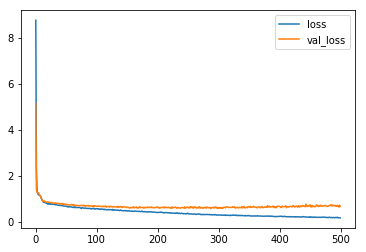

In [20]:
df_res[['loss','val_loss']].plot()

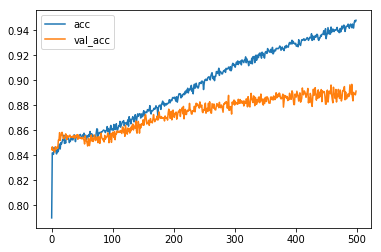

In [21]:
df_res[['acc','val_acc']].plot()

In [85]:
x

{'article_id': array([27]),
 'headline': array(['Top aide: Hillary ‘still not perfect in her head’, Wikileaks'],
       dtype='<U60'),
 'headline_vector': array([[-2.80251820e-02,  1.55666143e-01, -6.69659302e-02,
          1.17045075e-01,  1.25956535e-01, -4.20968495e-02,
          5.45715131e-02, -1.61940604e-01, -2.53995378e-02,
          1.66300142e+00, -8.94899219e-02, -1.05388761e-01,
          9.30799544e-03, -7.46809691e-02, -6.46852404e-02,
         -7.46380761e-02, -5.38155772e-02,  5.95024407e-01,
         -5.15634641e-02,  5.55658527e-02, -1.23773860e-02,
          4.13749963e-02,  5.98122971e-03, -8.83545354e-02,
          1.50243454e-02, -6.21039839e-03, -3.86625454e-02,
         -4.39293124e-02,  1.21606998e-01, -6.94209635e-02,
          1.80445844e-03,  7.84051791e-02,  5.88454753e-02,
          6.90723807e-02,  1.50678068e-01, -2.56143082e-02,
         -7.57065862e-02,  1.03167687e-02, -8.31812322e-02,
         -1.08155012e-01,  8.48623142e-02,  1.02632836e-01,
      

In [86]:
pred = model.predict(x)

In [87]:
pred_classes = np.argmax(pred[0], axis=-1)

In [30]:
pred_classes = [ 1282,  9724,  8156,  3082, 12878,     4,  9559,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0]

In [ ]:
for 

In [26]:
doc = nlp('Top aide: Hillary ‘still not perfect in her head’, Wikileaks')

In [35]:
words = []
for idx in pred_classes:
    if idx!=0:
        words.append(id_word_mapping[idx])

print(words)

[['Everyone'], ['Infant', 'infant'], ['Metzitzah', 'circumcisers', 'circumcising', 'circumcisions', 'metzitzah', 'circumcision', 'Mohels', 'bris', 'mohel', 'Circumcision', 'Circumcisions', 'Bris', 'mohels'], ['Election', 'landslide', 'recount', 'election', 'reelection', 'ELECTION', 'midterm'], ['justifying', 'imputing', 'Justifications', 'Appropriating', 'appropriating', 'exonerating', 'tantamount', 'justifications', 'positing', 'absolving'], ['to'], ['Councilor', 'mayor', 'councilor', 'Councilman', 'mayors', 'Mayors', 'mayoral', 'councilman', 'Mayoral']]


In [46]:
from spacy import tokens

In [18]:
df_key_value = pd.DataFrame(nlp.vocab.vectors.key2row,index=[0]).T.reset_index()
df_key_value.columns = ['key','value']

In [22]:
df_key_value[df_key_value['value']==1282]['key'].values[0]

14185809109698589018

In [25]:
nlp.vocab.vectors.data[1282]

array([-2.3680e-01,  2.4965e-01, -4.6016e-01, -1.8834e-01, -9.1247e-02,
       -8.8124e-04,  2.0540e-01, -2.1012e-01,  1.5035e-01,  2.9822e+00,
       -8.2018e-02, -1.8801e-01, -1.7675e-01,  9.5739e-02, -1.7001e-01,
       -1.1687e-01, -2.3019e-01,  5.5577e-01, -2.4702e-01,  6.0643e-02,
       -1.6225e-01, -1.0376e-01,  4.8407e-04,  4.0914e-02,  3.8364e-02,
        3.7064e-02,  2.3431e-01, -2.7053e-01, -6.5495e-02, -3.8465e-01,
       -1.4068e-01,  2.2680e-01, -2.2275e-01,  3.2285e-01,  1.1917e-01,
       -2.8075e-02,  8.7767e-02,  2.2625e-01,  1.4805e-01,  2.5788e-01,
        9.8710e-02,  1.3558e-02, -9.7951e-02,  1.7697e-01,  8.9398e-02,
        3.4257e-01, -2.7444e-01,  1.7439e-01, -3.5160e-02, -2.6952e-02,
       -1.7450e-01, -1.4403e-01, -8.8885e-02, -2.4063e-01, -8.6711e-02,
        8.8317e-03, -6.1302e-02,  2.6626e-03, -3.2778e-01, -4.0524e-02,
       -5.9312e-02, -2.3530e-01, -1.8762e-01, -1.1697e-01,  1.1222e-01,
       -3.1953e-01, -3.0420e-01,  3.8398e-01,  1.3481e-01,  1.94

In [71]:
len(np.unique(list(nlp.vocab.vectors.key2row.keys()))),len(np.unique(list(nlp.vocab.vectors.key2row.values())))

(684830, 20000)

In [24]:
vocab_dict = {}

1658

In [38]:
counter = 0
for s in nlp.vocab.strings:
    print(s.
    counter+=1
    if counter==100:
        break
    

ValueError: substring not found